<a href="https://colab.research.google.com/github/giuli-raffin/Procesamiento-de-Imagenes/blob/master/pdi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


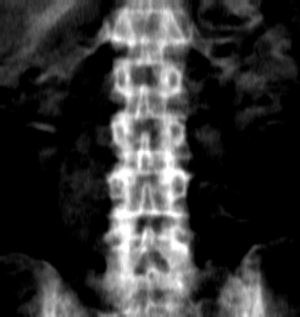

In [ ]:
import matplotlib.image as img
import numpy as npy
import cv2 as cv
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

disco = '/content/drive'
from google.colab import drive
drive.mount(disco)
path = '/MyDrive/images/'

m = img.imread(disco + path +"0aippqarut.tif");
cv2_imshow(m)

Funciones auxiliares

In [ ]:
#flood fill
def floodfill(img):
      #mitad derecha
      im_floodfill_d = img.copy()
      h, w = m.shape[:2]
      mask = npy.zeros((h+2, w+2), npy.uint8)
      cv.floodFill(im_floodfill_d, mask, (0,0), 255);
      cv.bitwise_not(im_floodfill_d)
      #cv2_imshow(im_floodfill_d)

      #mitad izquierda
      im_floodfill_i = img.copy()
      h, w = m.shape[:2]
      mask = npy.zeros((h+2, w+2), npy.uint8)
      cv.floodFill(im_floodfill_i, mask, (255,255), 255);
      cv.bitwise_not(im_floodfill_i)
      #cv2_imshow(im_floodfill_i)

      #nos quedamos con los agujeros -> lo que tienen distinto se hace blanco
      im_floodfill = cv.bitwise_or(im_floodfill_d,im_floodfill_i)
      #cv2_imshow(im_floodfill)

      #invertimos
      im_floodfill_inv = cv.bitwise_not(im_floodfill)
      #cv2_imshow(im_floodfill_inv)

      #superponemos
      return (im_floodfill_inv | img)

#opening
def opening(img):
      kernel = npy.ones((3,3), npy.uint8)
      return (cv.morphologyEx(img, cv.MORPH_OPEN, kernel,iterations=2))

#region growing
def region_growing(img, seed, threshold=5):
    # Inicializacion
    rows, cols = img.shape
    region_mean = img[seed]
    region_size = 1
    region = npy.zeros_like(img)
    region.fill(0)
    region[seed] = 255

    #vectores de movimiento para recorrer vecinos (8 conectividad)
    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    stack = [seed]

    while stack:
        x, y = stack.pop()

        for dx, dy in neighbors:
            xn, yn = x + dx, y + dy

            if 0 <= xn < rows and 0 <= yn < cols and region[xn, yn] == 0:
                intensity_difference = abs(int(img[xn, yn]) - int(region_mean))

                if intensity_difference < threshold:
                    region[xn, yn] = 255
                    stack.append((xn, yn))
                    region_mean = (region_mean * region_size + img[xn, yn]) / (region_size + 1)
                    region_size += 1

    return region


def deteccion_rx_rg(img):
      img_rg = img.copy()

      #posicion del ultimo pixel (esquina inferior derecha) para la semilla del lado derecho del region growing
      rows, cols = img_rg.shape
      ultimo_pixel = (rows - 1, cols - 1)

      #posicion de la semilla para el lado izquierdo del region growing
      seed_point = (0,0)

      #aplico region growing
      segmented_imgi = region_growing(img_rg, seed_point)
      segmented_imgd = region_growing(img_rg, ultimo_pixel)

      #imprime la imagen segmentada
      #cv2_imshow(segmented_imgd)
      #cv2_imshow(segmented_imgi)

      segm = cv.bitwise_or(segmented_imgd,segmented_imgi)
      return segm

# **Metodo 1:** Flood fill, operador morfologico opening y threshold Gaussiano

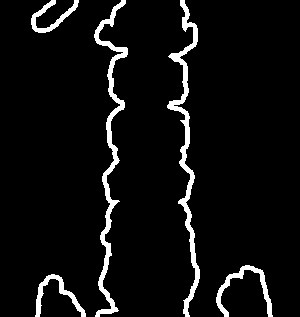

In [ ]:
#floodfill + morphology (opening) + threshold
def ff_morph (img):
  ret, thresh = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
  ff = floodfill(thresh)
  openm = opening(ff)
  tg = (cv.adaptiveThreshold(openm,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,2))
  return cv.bitwise_not(tg)

cv2_imshow(ff_morph(m))

# **Metodo 2:** Region Growing y borde de Laplace

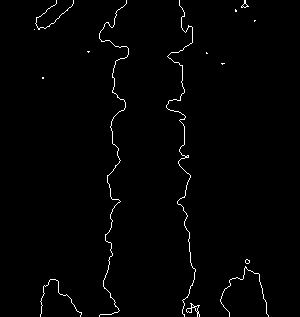

In [ ]:
#laplacian border + region growing
def laplace_rg (img):
  ret, img_thresh = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
  img_segm = deteccion_rx_rg(img_thresh)
  return cv.Laplacian(img_segm,cv.CV_64F)

cv2_imshow(laplace_rg(m))

# **Metodo 3:** Region Growing y borde de Prewitt

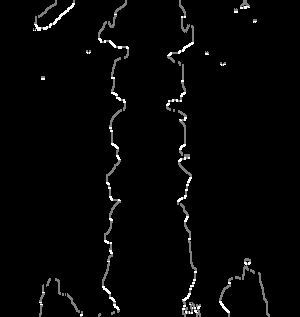

In [ ]:
#prewitt border + region growing
#prewitt
def prewitt(img):
  kernel_x = npy.array([[-1, 0, 1],
                      [-1, 0, 1],
                      [-1, 0, 1]])

  kernel_xx = npy.array([[1, 0, -1],
                      [1, 0, -1],
                      [1, 0, -1]])

  #bordes verticales
  kernel_y = npy.array([[-1, -1, -1],
                      [0, 0, 0],
                      [1, 1, 1]])

  edges_x = cv.filter2D(img, -1, kernel_x)
  edges_xx = cv.filter2D(img,-1,kernel_xx)
  edg_x = edges_x | edges_xx
  edges_y = cv.filter2D(img, -1, kernel_y)

  #combinar los bordes horizontales y verticales para obtener el resultado final
  edges = cv.addWeighted(edg_x, 0.5, edges_y, 0.5, 0)
  return edges

def prewitt_rg (img):
  ret, img_thresh = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
  img_segm = deteccion_rx_rg(img_thresh)
  return prewitt(img_segm)

cv2_imshow(prewitt_rg(m))

# Pruebas descartadas

Los tres metodos mostrados debajo fueros descartados pero los dejamos a modo de ilustracion para comparar con los elegidos y analizar sus defectos


*   **Sobel:** fue descartado ya que no fue una tecnica que nos permita detectar los bordes de manera continua y discernible
*   **Laplace y Prewitt:** fueron descartados ya que ambos se quedaban con la parte de adentro de las vértebras, sin embargo los utilizamos en conjunto con region growing, lo que si nos dio resultados favorables



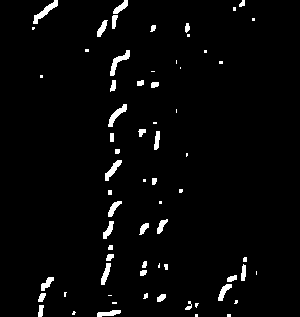

In [ ]:
#prueba sobel
def sobel(img):
  ret, thresh = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
  sobelx = cv.Sobel(thresh,cv.CV_64F,1,0,ksize=5)
  sobely = cv.Sobel(thresh,cv.CV_64F,0,1,ksize=5)
  #cv2_imshow(sobelx)
  #cv2_imshow(sobely)
  arrsx = npy.array(sobelx)
  arrsy = npy.array(sobely)
  return (cv.bitwise_or(arrsx, arrsy))

cv2_imshow(sobel(m))

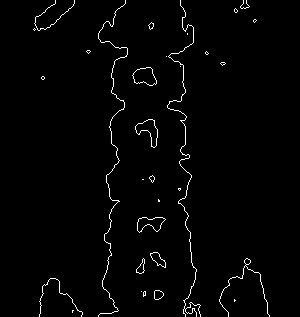

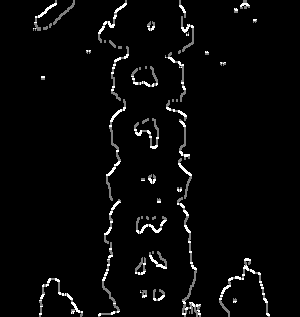

In [ ]:
#mascaras de deteccion de bordes antes de region growing
#laplacian border
ret, thresh_lp = cv.threshold(m,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
laplacian = cv.Laplacian(thresh_lp,cv.CV_64F)
cv2_imshow(laplacian)

#prewitt
cv2_imshow(prewitt(thresh_lp))

### **Medición de la efectividad de la segmentacion** mendiante Pyradiomics

In [ ]:
pip install pyradiomics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 34.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 24.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import radiomics
from radiomics import featureextractor

params = {
    'binWidth': 25,
    'resampledPixelSpacing': None,
    'interpolator': 'sitkBSpline',
    'enableCExtensions': True
}
extractor = featureextractor.RadiomicsFeatureExtractor(**params)

m2 = m.copy()
cv.imwrite('m2.png',m2)

#pyradiomics FloodFill
ff = ff_morph(m)
ff[ff > 0] = 1 #poner un 1 en todos los valores distintos de 0
cv.imwrite('ff.png',ff)

results_ff = extractor.execute("m2.png", "ff.png")

#pyradiomics Laplace
lap = laplace_rg(m)
lap[lap > 0] = 1 #poner un 1 en todos los valores distintos de 0
cv.imwrite('lap.png',lap)

results_lap = extractor.execute("m2.png", "lap.png")

#pyradiomics Prewitt
prg = prewitt_rg(m)
prg[prg > 0] = 1 #poner un 1 en todos los valores distintos de 0
cv.imwrite('prewitt.png',prg)

results_prewitt = extractor.execute("m2.png", "prewitt.png")

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Applying custom setting overrides: {'binWidth': 25, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'enableCExtensions': True}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D 

In [ ]:
for key, value in results_ff.items():
    print(f"{key}: {value}")

diagnostics_Versions_PyRadiomics: v3.0.1
diagnostics_Versions_Numpy: 1.25.2
diagnostics_Versions_SimpleITK: 2.3.1
diagnostics_Versions_PyWavelet: 1.6.0
diagnostics_Versions_Python: 3.10.12
diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25, 'enableCExtensions': True}
diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
diagnostics_Image-original_Hash: 15b1b943b7b1c2caa5a40f41a3afe5b107f23953
diagnostics_Image-original_Dimensionality: 2D
diagnostics_Image-original_Spacing: (1.0, 1.0)
diagnostics_Image-original_Size: (300, 317)
diagnostics_Image-original_Mean: 52.615699263932704
diagnostics_Image-original_Minimum: 0.0
diagnostics_Image-original_Maximu

In [ ]:
for key, value in results_lap.items():
    print(f"{key}: {value}")

diagnostics_Versions_PyRadiomics: v3.0.1
diagnostics_Versions_Numpy: 1.25.2
diagnostics_Versions_SimpleITK: 2.3.1
diagnostics_Versions_PyWavelet: 1.6.0
diagnostics_Versions_Python: 3.10.12
diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25, 'enableCExtensions': True}
diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
diagnostics_Image-original_Hash: 15b1b943b7b1c2caa5a40f41a3afe5b107f23953
diagnostics_Image-original_Dimensionality: 2D
diagnostics_Image-original_Spacing: (1.0, 1.0)
diagnostics_Image-original_Size: (300, 317)
diagnostics_Image-original_Mean: 52.615699263932704
diagnostics_Image-original_Minimum: 0.0
diagnostics_Image-original_Maximu

In [ ]:
for key, value in results_prewitt.items():
    print(f"{key}: {value}")

diagnostics_Versions_PyRadiomics: v3.0.1
diagnostics_Versions_Numpy: 1.25.2
diagnostics_Versions_SimpleITK: 2.3.1
diagnostics_Versions_PyWavelet: 1.6.0
diagnostics_Versions_Python: 3.10.12
diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25, 'enableCExtensions': True}
diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
diagnostics_Image-original_Hash: 15b1b943b7b1c2caa5a40f41a3afe5b107f23953
diagnostics_Image-original_Dimensionality: 2D
diagnostics_Image-original_Spacing: (1.0, 1.0)
diagnostics_Image-original_Size: (300, 317)
diagnostics_Image-original_Mean: 52.615699263932704
diagnostics_Image-original_Minimum: 0.0
diagnostics_Image-original_Maximu